In [1]:
import numpy as np
import pandas as pd
import pygmo as pg
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
from IPython.display import Image


pd.set_option('display.max_rows', 500)

from sklearn.externals import joblib 
from config import MAX_DISCOUNT, FEATURES

%matplotlib inline
%load_ext line_profiler

In [2]:
df=pd.read_csv('training_data_randn.csv', nrows=20000)
print(len(df))

20000


In [3]:
cols_x = FEATURES
col_y = 'is_deal'
col_p = 'Probability'
print('Input features of the propensity model\n{}'.format(cols_x))

Input features of the propensity model
['Discount', 'RRP', 'Service', 'Elasticity', 'nPurchases', 'nPurchasesDiscount', 'AvgPrice', 'AvgService', 'AvgDiscount', 'x_c0', 'x_c1']


In [4]:
model = joblib.load('propensity_model_sklearn_mlp.pkl')

In [5]:
%%timeit
model.predict_proba(df[cols_x])[:, 1]

17.2 ms ± 545 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Each time the optimization algorithm attempts a new solution, we will need to call the inference function of the predictive model once. This is likely to be your computation bottleneck. Try everything (ML framework, model complexity, etc) to make this faster.

Alternatively, build a surrogate model for the aggregated metrics.

# Single-objective optimization

## User Defined Problem (UDP)

Let's try to find out the discount amount for each product in order to maximize our profit.

\begin{equation*}
Profit = RRP - Discount - Cost
\end{equation*}

First let's create our problem class:

In [6]:
class optimal_discount_per_product:
    def __init__(self, df, model): 
        self.cols_x = FEATURES
        self.df = df     
        self.model = model
        self.p_ids = df['product_id'].unique()
        self.p_ids.sort()
        self.n_products = len(self.p_ids)
        
    def propensity_at_discount(self, dv):
        prod_discount = dict(zip(self.p_ids, dv))
        amt_discount = self.df['product_id'].map(prod_discount) * self.df['RRP']
        X = self.df[self.cols_x].values
        X[:, 0] = amt_discount
        y_prob = self.model.predict_proba(X)[:, 1]
        return y_prob, amt_discount        
        
    def get_bounds(self): # box bounds of decision vector (dv)
        return ([0,]*self.n_products, [MAX_DISCOUNT, ]*self.n_products)

In [7]:
class optimal_discount_per_product_for_max_profit(optimal_discount_per_product):
    def __init__(self, df, model): 
        super().__init__(df, model)
    
    def profit(self, y_prob, amt_discount):
        return np.dot(self.df['RRP'] - amt_discount - self.df['Cost'], y_prob) 
        
    def fitness(self, dv): # fitness given decision vector (dv)
        y_prob, amt_discount = self.propensity_at_discount(dv)
        profit = self.profit(y_prob, amt_discount)
        return [-profit/1e6,]   # We want to maximize profit, hence set the (minimization) objective to minus profit

Notes:
* Mandatory methods you must implement: ``get_bounds(self)`` and ``fitness(self, x)``
* PyGMO2 assume the problem is about minimization in every objective. Adapt your objectives accordingly.
* PyGMO2 by default treat the problem as single-objective, no constraint, no gradient, continuous decision vectors, etc.
* Return of fitness() must be a list, even for single-objective problems

In [8]:
problem_profit = pg.problem(optimal_discount_per_product_for_max_profit(df, model))

## Population
Population is a collection of individual solutions that will be evoled by the algorithm

In [9]:
pop = pg.population(problem_profit, size=10)

In [10]:
pop.get_x(), pop.get_f()

(array([[0.21395443, 0.33096178, 0.34744501, 0.03852322, 0.30572622],
        [0.1879899 , 0.02998538, 0.05996235, 0.24205006, 0.22328538],
        [0.36777153, 0.37324895, 0.04870838, 0.04785762, 0.08644784],
        [0.35882307, 0.2161029 , 0.37374009, 0.2289279 , 0.38237154],
        [0.34753723, 0.33713852, 0.23019886, 0.06799873, 0.30472204],
        [0.39329125, 0.2347921 , 0.2833977 , 0.06789944, 0.03617671],
        [0.39671107, 0.20557732, 0.34525128, 0.13559946, 0.31420638],
        [0.30980307, 0.14824749, 0.02416533, 0.35695122, 0.23963751],
        [0.0724661 , 0.26650929, 0.24195422, 0.03589438, 0.34210073],
        [0.185619  , 0.3026822 , 0.19469292, 0.26451633, 0.1496102 ]]),
 array([[-7.30170778],
        [-7.72843716],
        [-7.22091952],
        [-6.96667541],
        [-7.32455618],
        [-7.80038972],
        [-7.38344842],
        [-7.15586098],
        [-7.41039938],
        [-7.6341959 ]]))

## Algorithm

For the single-objective problem, let's try the differential evolution (DE) as a first attempt. 

Full list of available algorithms and their applicability can be found at [this link](https://esa.github.io/pagmo2/docs/algorithm_list.html)

In [11]:
algo = pg.algorithm(pg.de(gen = 100))
algo.set_verbosity(10) # Set interval of evolution for the algorithm to fill in logging information

In [12]:
pop = algo.evolve(pop)

In [13]:
best_x_rev = pop.champion_x
best_f_rev = pop.champion_f
print('Maximum profit £{:.3f}M to be achieved with discount rates:'.format(-best_f_rev[0])) 
for i,v in enumerate(best_x_rev):
    print('product {}:\t {:.1f}%'.format(i, 100*v))

Maximum profit £8.277M to be achieved with discount rates:
product 0:	 22.3%
product 1:	 21.3%
product 2:	 26.4%
product 3:	 18.3%
product 4:	 22.9%


We can also inspect the log of the algorithm since we have specified verbosity

In [14]:
algo.extract(pg.de).get_log()

[(1, 10, -7.800389724168806, 0.9217777337936297, 0.644528746034962),
 (11, 110, -8.061432955720088, 0.6643609278386413, 0.3132959379925673),
 (21, 210, -8.254823737554196, 0.1678990247295594, 0.15580015160852057),
 (31, 310, -8.257963762373288, 0.3143673913081567, 0.03299208233967299),
 (41, 410, -8.2597886008142, 0.11704603546936967, 0.0328760270184425),
 (51, 510, -8.269308568650253, 0.041202603492181016, 0.019025599484534084),
 (61, 610, -8.271171066091041, 0.2031292145181844, 0.008478876021017712),
 (71, 710, -8.275592201385244, 0.2089352895624968, 0.006283632734991329),
 (81, 810, -8.276601763575895, 0.01933262976269512, 0.00243231892159379),
 (91, 910, -8.276750904968933, 0.006142614640995969, 0.00039935941321722623)]

# Multi-objective optimization (MOO)

## Multi-objective problem (UDP)

But our products also generate revenue from value-added services after purchase. 

We want to strike a good balance between upfront profit (objective 1) and future income from service (objective 2).

First let's create our problem class:

In [15]:
class optimal_discount_per_product_for_max_profit_and_service(optimal_discount_per_product):
    def __init__(self, df, model): 
        super().__init__(df, model)
    
    def profit(self, y_prob, amt_discount):
        return np.dot(self.df['RRP'] - amt_discount - self.df['Cost'], y_prob) 

    def service(self, y_prob):
        return np.dot(self.df['Service'] , y_prob) 

    def get_nobj(self):
        return 2
    
    def fitness(self, dv): # fitness given decision vector (dv)
        y_prob, amt_discount = self.propensity_at_discount(dv)
        profit = self.profit(y_prob, amt_discount)
        service = self.service(y_prob)        
        return [-profit/1e6,-service/1e6]   # Minimization objectives


Notes:
* You need to explicitly indicate the problem as multi-objective with ``get_nobj(self)``
* PyGMO always try to minimize the objectives. 

In [16]:
problem_profit_service = pg.problem(optimal_discount_per_product_for_max_profit_and_service(df, model))

## Population: Pareto frontiers and hypervolume

In [17]:
pop_init = pg.population(problem_profit_service,size=32)

The goal of multi-objective optimization is not to find a single best solution, but to provide a group of solutions which are not **dominated** by other solutions. A solution is said to be dominated if there is another solution which is better than it in every objective.

The ``fast_non_dominated_sorting()`` function process a list of objectives and return the sorted Pareto frontiers.

In [18]:
ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(pop_init.get_f())
ndf

[array([ 2, 11, 12, 20, 22, 30], dtype=uint64),
 array([18,  4, 15, 21, 29], dtype=uint64),
 array([13, 16,  7, 17,  1,  8, 23], dtype=uint64),
 array([27, 31, 25], dtype=uint64),
 array([ 6, 24,  5], dtype=uint64),
 array([28,  9, 14], dtype=uint64),
 array([ 0, 26,  3], dtype=uint64),
 array([10, 19], dtype=uint64)]

* *ndf* (``list`` of 1D NumPy int array): the non dominated fronts. Each element is a list of indices in this frontier.
* *dl* (``list`` of 1D NumPy int array): the domination list. Each element is a list of indices dominated by this point.
* *dc* (1D NumPy int array): the domination count. Number of indices dominate this point.
* *ndr* (1D NumPy int array): the non domination ranks. The rank of the frontier this point belongs to.

In [19]:
def plot_2D_frontiers(fs, obj_names=('Objective 1', 'Objective 2'), **kwarg):
    df = pd.DataFrame(fs, columns = obj_names).sort_values(obj_names[0])   
    df.loc[:, 'pareto_group'] = pg.fast_non_dominated_sorting(df.values)[3]
    df.groupby('pareto_group').plot(obj_names[0], obj_names[1], style='o-', legend=False, **kwarg, ax=plt.gca())
    plt.gca().set_ylabel(obj_names[1])
    return
   

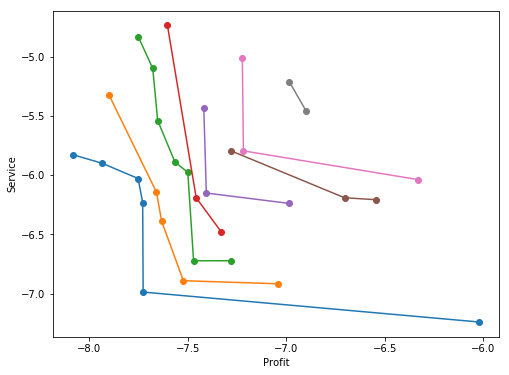

In [20]:
plot_2D_frontiers(pop_init.get_f(), ('Profit', 'Service'), figsize=(8,6)) 

To have a single value measure of the quality of multi-objective optimization, we use the **hypervolume** metrics:
* 2D: area between the Pareto frontier curve and a reference point
* 3D: volume between the Pareto frontier surface and a reference point
* 3+D: hypervolumn between the Pareto frontier hypersurface and a reference point

https://esa.github.io/pagmo2/docs/python/tutorials/hypervolume.html

In [21]:
refpoint = [0, 0]
hv = pg.hypervolume(pop_init)
hv.compute(refpoint)

57.60870342167965

## Algorithm

Let's first try the NSGAII algorithm

https://esa.github.io/pagmo2/docs/python/algorithms/py_algorithms.html#pygmo.nsga2

In [22]:
algo = pg.algorithm(pg.nsga2(gen = 256))

In [23]:
pop = algo.evolve(pop_init)

## The optimized solutions

In [24]:
hv = pg.hypervolume(pop)
hv.compute(refpoint)

59.973476892373746

Looks like we achieved some improvement from the optimization!

In [25]:
ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(pop.get_f())
ndf

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
       dtype=uint64)]

After optimization we only have one frontier now. i.e. every solution in the population is non-dominated

In [26]:
fits, vectors = pop.get_f(), pop.get_x()
idx_sorted = fits.argsort(0)[:, 0]
df_solutions = pd.DataFrame(vectors[idx_sorted].round(3), columns=['Discount_%d'%i for i in range(5)])
df_solutions.loc[:, 'Profit'] = -fits[idx_sorted, 0]
df_solutions.loc[:, 'Service'] = -fits[idx_sorted, 1]
df_solutions

,Discount_0,Discount_1,Discount_2,Discount_3,Discount_4,Profit,Service
0,0.222,0.212,0.262,0.183,0.229,8.276892,6.535009
1,0.228,0.214,0.262,0.183,0.229,8.276013,6.545189
2,0.222,0.217,0.262,0.183,0.240,8.269212,6.602673
3,0.222,0.217,0.273,0.183,0.240,8.264152,6.652865
4,0.232,0.226,0.273,0.188,0.241,8.252907,6.692700
5,0.224,0.217,0.298,0.184,0.240,8.217109,6.727365
6,0.218,0.219,0.304,0.183,0.243,8.189721,6.756338
7,0.224,0.226,0.295,0.183,0.263,8.157998,6.822848
8,0.224,0.226,0.299,0.184,0.270,8.117581,6.847865
9,0.222,0.217,0.301,0.223,0.272,8.050598,6.872845


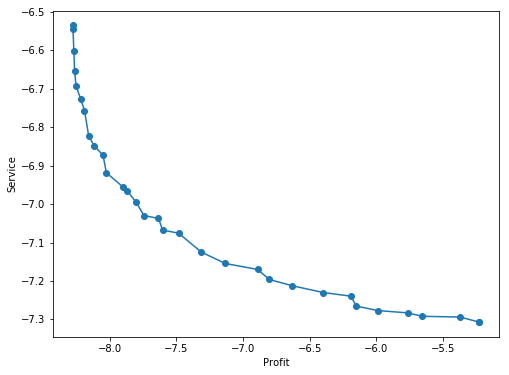

In [27]:
plot_2D_frontiers(pop.get_f(), ('Profit', 'Service'), figsize=(8,6)) 

## A little more visability over evolution

We can manually repeat the call of ``evolve()`` multiple times, with reduced number of generations per call. Thus we can monitor the progress of the population over evolutions.

In [63]:
n_gen = 256
pop = pg.population(problem_profit_service,size=32, seed = 12345)  # re-initialize with identical seed

algo = pg.algorithm(pg.nsga2(gen = 1))  # One generation for each call of algo.evolve()
# algo = pg.algorithm(pg.moead(gen = 1))  # One generation for each call of algo.evolve()

log_pop = []

hv = pg.hypervolume(pop).compute(refpoint)
log_pop.append((pop.get_x(), pop.get_f(), hv))
print('Evolution-0:\t hypervolume = {:.2f}'.format(hv))
for i in range(n_gen):
    pop = algo.evolve(pop)
    hv = pg.hypervolume(pop).compute(refpoint)
    log_pop.append((pop.get_x(), pop.get_f(), hv))
    if np.log2(i+1).is_integer():
        print('Evolution-{}:\t hypervolume = {:.2f}'.format(i+1, hv))


Evolution-0:	 hypervolume = 57.13
Evolution-1:	 hypervolume = 57.61
Evolution-2:	 hypervolume = 57.73
Evolution-4:	 hypervolume = 58.00
Evolution-8:	 hypervolume = 58.61
Evolution-16:	 hypervolume = 58.96
Evolution-32:	 hypervolume = 59.15
Evolution-64:	 hypervolume = 59.50
Evolution-128:	 hypervolume = 59.80
Evolution-256:	 hypervolume = 59.91


Text(0,0.5,'hypervolume')

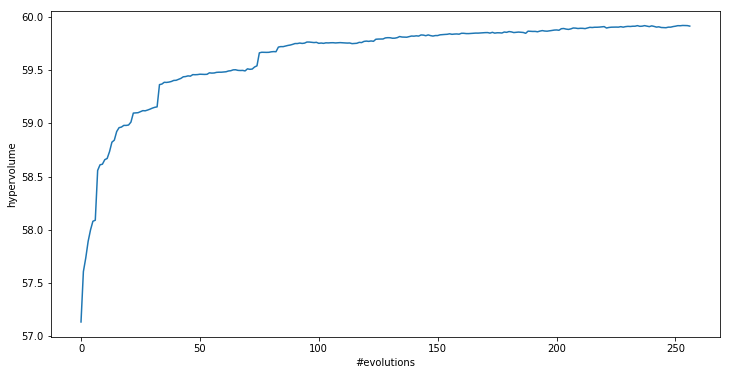

In [64]:
plt.figure(figsize=(12,6))
plt.plot(np.asarray(log_pop)[:, 2])
plt.gca().set_xlabel('#evolutions')
plt.gca().set_ylabel('hypervolume')

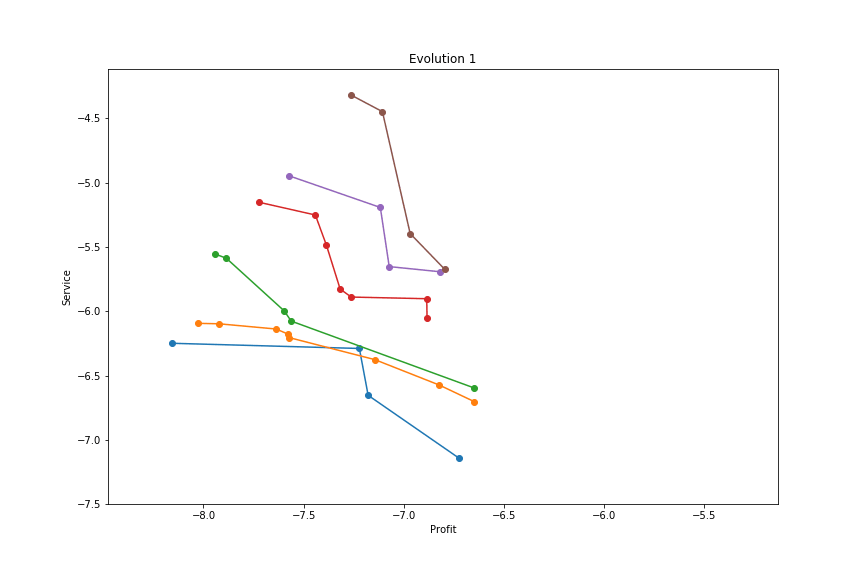

<Figure size 864x576 with 0 Axes>

In [65]:
x_max = np.array([p[1] for p in log_pop])[:,:, 0].max() + 0.2
x_min = np.array([p[1] for p in log_pop])[:,:, 0].min() - 0.2
y_max = np.array([p[1] for p in log_pop])[:,:, 1].max() + 0.2
y_min = np.array([p[1] for p in log_pop])[:,:, 1].min() - 0.2
axis_range = ((x_min, x_max), (y_min, y_max))
images = []

for i, (dvs, fs, hv) in enumerate(log_pop):
    if i<20 or (i<100 and i%5==0) or (i%10==0):
        ax = plot_2D_frontiers(fs, ('Profit', 'Service'), 
                               xlim=(x_min, x_max), ylim=(y_min, y_max), 
                               figsize=(12,8), title='Evolution %d'%(i+1)) 
        fname = 'tmp.png'
        plt.savefig(fname)
        plt.clf()
        images.append(imageio.imread(fname))

fname_gif = 'pareto_evolution_nsga2.gif'
imageio.mimsave(fname_gif, images, duration=0.2)
Image(filename=fname_gif)


# Optimization with constraints

Now let's say we also have a limited budget for production cost. We want to find the optimal frontier of profit-service without going beyond our cost budget. 

This becomes an optimization problem with inequality constraint. 



## UDP with constraints

In [31]:
class optimal_discount_per_product_for_max_profit_and_service_with_cost_budget(optimal_discount_per_product):
    def __init__(self, df, model, max_cost): 
        super().__init__(df, model)
        self.max_cost = max_cost
    
    def profit(self, y_prob, amt_discount):
        return np.dot(self.df['RRP'] - amt_discount - self.df['Cost'], y_prob) 

    def service(self, y_prob):
        return np.dot(self.df['Service'] , y_prob) 

    def cost(self, y_prob):
        return np.dot(self.df['Cost'] , y_prob) 

    def get_nobj(self):
        return 2
    
    # Inequality Constraints
    def get_nic(self):
        return 1

    # Equality Constraints
    def get_nec(self):
        return 0
    
    def fitness(self, dv): # fitness given decision vector (dv)
        y_prob, amt_discount = self.propensity_at_discount(dv)
        profit  = self.profit(y_prob, amt_discount)
        service = self.service(y_prob)        
        cost     = self.cost(y_prob)        
        return [-profit/1e6,-service/1e6, cost - self.max_cost]   # Minimization objectives



* We need to explicitly declare the number of constraints by implementing ``get_nic(self)`` and ``get_nec(self)`` 
* The return list of ``fitness(self, dv)`` should be concatenation of objectives, equality constraint, inequality constraint. 
* For equality constraint, assuming return value $= 0$. e.g. for constraint $v = v_0$, return $v-v_0$ 
* For inequality constraint, assuming return value $\le 0$. e.g. for constraint $v \ge v_0$, return $v_0 - v$ 


In [32]:
max_cost = 8e6
problem_profit_service_costbudget = pg.problem(optimal_discount_per_product_for_max_profit_and_service_with_cost_budget(df, model, max_cost))

## Unconstrain meta-problem

PyGMO provided a ``unconstrain`` *meta-problem*, which transforms a constrained problem into an unconstrained problem. 

See details of implemented methods at
https://esa.github.io/pagmo2/docs/python/problems/py_problems.html?highlight=unconstrain#pygmo.unconstrain

In [33]:
problem_profit_service_costbudget_uc = pg.unconstrain(prob=problem_profit_service_costbudget, method = "death penalty")
pop = pg.population(problem_profit_service_costbudget_uc,size=32)  # re-initialize
pop.get_f().shape

(32, 2)

The objective function from the ``unconstrain`` meta-problem has only two objectives. This is because the "death penalty" method simply penalize the objectives when the constraint is violated. 

In [34]:
algo = pg.algorithm(pg.nsga2(gen = 256))
pop = algo.evolve(pop)

In [35]:
hv = pg.hypervolume(pop)
hv.compute(refpoint)

58.57868312169226

The hypervolume from this optimization is worse than before, due to the cost budget constraint

In [36]:
fits, vectors = pop.get_f(), pop.get_x()
idx_sorted = fits.argsort(0)[:, 0]
df_solutions = pd.DataFrame(vectors[idx_sorted], columns=['Discount_%d'%i for i in range(5)])
df_solutions.loc[:, 'Profit'] = -fits[idx_sorted, 0]
df_solutions.loc[:, 'Service'] = -fits[idx_sorted, 1]
df_solutions.loc[:, 'BelowCostBudget'] = df_solutions.apply(lambda row: problem_profit_service_costbudget.fitness(row[:5])[2], axis=1)
df_solutions

,Discount_0,Discount_1,Discount_2,Discount_3,Discount_4,Profit,Service,BelowCostBudget
0,0.221998,0.211747,0.262610,0.182429,0.228908,8.276920,6.531932,-480820.014613
1,0.221998,0.211747,0.262610,0.182429,0.228908,8.276920,6.531932,-480820.014613
2,0.221998,0.211747,0.262610,0.182429,0.234837,8.274858,6.565860,-441178.504610
3,0.221998,0.217832,0.263498,0.187091,0.234837,8.272575,6.590629,-394372.006113
4,0.221707,0.217003,0.280190,0.182956,0.228560,8.262454,6.617208,-436321.933741
5,0.228783,0.211543,0.278846,0.182956,0.241884,8.254613,6.677511,-359529.925017
6,0.228783,0.214295,0.279545,0.182956,0.241884,8.253425,6.686955,-351201.160061
7,0.228783,0.214295,0.279545,0.182956,0.250386,8.235597,6.721505,-310832.163994
8,0.238375,0.218707,0.291209,0.199592,0.245624,8.207729,6.775332,-196608.886938
9,0.241038,0.233186,0.291209,0.199592,0.245624,8.191205,6.806275,-163568.159002


# Parallelization

PyGMO provides powerful asynchronous parallelization functionality through the generalized island model. 

## Island

Unit parallelization block. It encapsulates:
* A problem
* A population
* An algorithm    

Type of islands:
* Multi-threading
* Multi-processing
* Ipyparallel

By default PyGMO will automatically choose the type of island depending on the platform, python version, the algorithm and population.


In [38]:
def create_nsga2_island(cr, m):
    return pg.island(algo = pg.nsga2(gen = 20, cr=cr, m=m), 
                     prob = optimal_discount_per_product_for_max_profit_and_service(df, model), 
                     size=32)

islands_conf = [(cr, m) for cr in np.linspace(0.65, 0.95, 4) for m in np.logspace(-2, -1, 3)]
islands = [create_nsga2_island(*conf) for conf in islands_conf]

In [46]:
islands[0].get_name()

'Multiprocessing island'

In [39]:
_ = [isl.evolve() for isl in islands]

Calling ``evolve()`` will start the optimization on a parallel thread/process/machine. You can continue with current thread or use ``wait()`` to pause for the return.

In [40]:
_ = [isl.wait() for isl in islands]

cr=0.65	 m=0.010 	 hypervolume=59.08
cr=0.65	 m=0.032 	 hypervolume=59.25
cr=0.65	 m=0.100 	 hypervolume=59.67
cr=0.75	 m=0.010 	 hypervolume=59.03
cr=0.75	 m=0.032 	 hypervolume=59.22
cr=0.75	 m=0.100 	 hypervolume=59.42
cr=0.85	 m=0.010 	 hypervolume=58.62
cr=0.85	 m=0.032 	 hypervolume=59.04
cr=0.85	 m=0.100 	 hypervolume=59.50
cr=0.95	 m=0.010 	 hypervolume=59.08
cr=0.95	 m=0.032 	 hypervolume=59.49
cr=0.95	 m=0.100 	 hypervolume=59.53


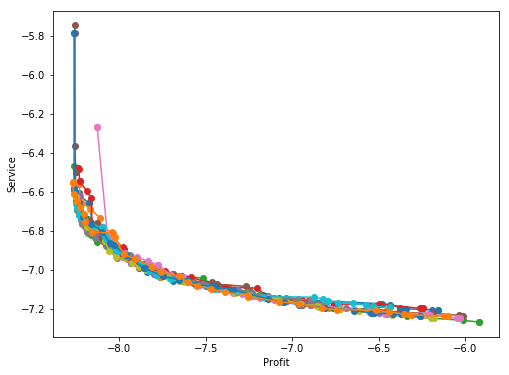

In [42]:
for i,isl in enumerate(islands):
    pop = isl.get_population()
    plot_2D_frontiers(pop.get_f(), ('Profit', 'Service'),  figsize=(8,6)) 
    print('cr={:.2f}\t m={:.3f} \t hypervolume={:.2f}'.format(islands_conf[i][0], islands_conf[i][1], pg.hypervolume(pop).compute(refpoint)))

## Archipelago

A collection of islands with asynchronous migration (*WIP in PyGMO2*) between the islands during evolution.

In [47]:
archi = pg.archipelago()
for cr in np.linspace(0.65, 0.95, 4):
    for m in np.logspace(-2, -1, 3):
        archi.push_back(algo = pg.nsga2(gen = 10, cr = cr, m = m),
                        prob = optimal_discount_per_product_for_max_profit_and_service(df, model), 
                        size=32)

In [48]:
archi

Number of islands: 12
Status: idle

Islands summaries:

	#   Type                    Algo      Prob                                                                        Size  Status  
	--------------------------------------------------------------------------------------------------------------------------------
	0   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_profit_and_service'>  32    idle    
	1   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_profit_and_service'>  32    idle    
	2   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_profit_and_service'>  32    idle    
	3   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_profit_and_service'>  32    idle    
	4   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_profit_and_service'>  32    idle    
	5   Multiprocessing island  NSGA-

You can iterate over the archipelago, which will get you individual islands

cr=0.65	 m=0.010 	 hypervolume=56.60
cr=0.65	 m=0.032 	 hypervolume=55.45
cr=0.65	 m=0.100 	 hypervolume=56.58
cr=0.75	 m=0.010 	 hypervolume=56.44
cr=0.75	 m=0.032 	 hypervolume=55.21
cr=0.75	 m=0.100 	 hypervolume=56.06
cr=0.85	 m=0.010 	 hypervolume=56.81
cr=0.85	 m=0.032 	 hypervolume=54.96
cr=0.85	 m=0.100 	 hypervolume=57.00
cr=0.95	 m=0.010 	 hypervolume=56.73
cr=0.95	 m=0.032 	 hypervolume=54.26
cr=0.95	 m=0.100 	 hypervolume=54.53


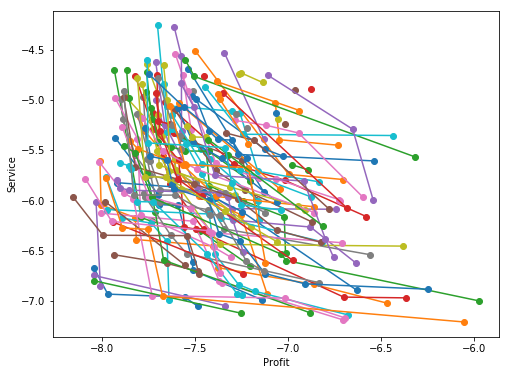

In [50]:
for i,isl in enumerate(archi):
    pop = isl.get_population()
    plot_2D_frontiers(pop.get_f(), ('Profit', 'Service'),  figsize=(8,6)) 
    print('cr={:.2f}\t m={:.3f} \t hypervolume={:.2f}'.format(islands_conf[i][0], islands_conf[i][1], pg.hypervolume(pop).compute(refpoint)))

In [51]:
archi.evolve()

In [52]:
archi

Number of islands: 12
Status: busy

Islands summaries:

	#   Type                    Algo      Prob                                                                        Size  Status  
	--------------------------------------------------------------------------------------------------------------------------------
	0   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_profit_and_service'>  32    busy    
	1   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_profit_and_service'>  32    busy    
	2   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_profit_and_service'>  32    busy    
	3   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_profit_and_service'>  32    busy    
	4   Multiprocessing island  NSGA-II:  <class '__main__.optimal_discount_per_product_for_max_profit_and_service'>  32    busy    
	5   Multiprocessing island  NSGA-

In [53]:
archi.wait()

cr=0.65	 m=0.010 	 hypervolume=58.48
cr=0.65	 m=0.032 	 hypervolume=58.56
cr=0.65	 m=0.100 	 hypervolume=59.42
cr=0.75	 m=0.010 	 hypervolume=57.99
cr=0.75	 m=0.032 	 hypervolume=58.77
cr=0.75	 m=0.100 	 hypervolume=57.71
cr=0.85	 m=0.010 	 hypervolume=58.49
cr=0.85	 m=0.032 	 hypervolume=58.69
cr=0.85	 m=0.100 	 hypervolume=58.88
cr=0.95	 m=0.010 	 hypervolume=58.92
cr=0.95	 m=0.032 	 hypervolume=58.57
cr=0.95	 m=0.100 	 hypervolume=58.15


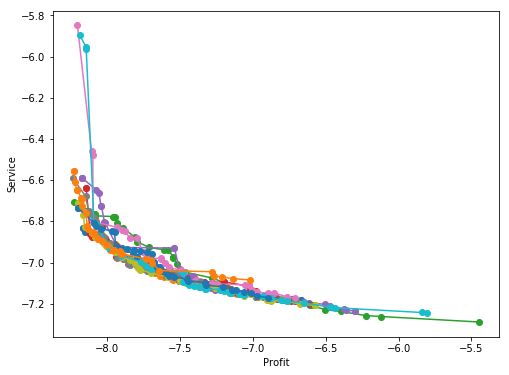

In [55]:
for i,isl in enumerate(archi):
    pop = isl.get_population()
    plot_2D_frontiers(pop.get_f(), ('Profit', 'Service'),  figsize=(8,6)) 
    print('cr={:.2f}\t m={:.3f} \t hypervolume={:.2f}'.format(islands_conf[i][0], islands_conf[i][1], pg.hypervolume(pop).compute(refpoint)))